# **Smoothed Fields**
### Voy a usar el paquete PyLians para hacer un suavizado de los campos de galaxias en diferentes escalas.

### *La idea es luego comparar esos campos suavizados con los generados por el BACCO emulator*

In [9]:
%pylab inline
import h5py
import MAS_library as MASL
import smoothing_library as SL

Populating the interactive namespace from numpy and matplotlib


In [6]:
mass = '2e-03'
path = '/mnt/projects/bias_mock/galaxies/'
filename = 'rhodm_eul'#'rhogalz_'+mass+'_eul_bias_expansion'
density = np.load(path+filename+'.npy')
delta = density/np.mean(density) - 1

In [7]:
grid = delta.shape[0]
BoxSize = 1440
Filter = 'Top-Hat'
threads = 10

In [8]:
r = [0,5,10,15,20]
R = 20
for R in r:
    print(R)
    W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
    field_smoothed = SL.field_smoothing(delta, W_k, threads)
    np.save(path+'/smoothed_fields/PL/'+filename+'_'+str(R)+'.npy',field_smoothed)

0
5
10
15
20


In [19]:
stop

NameError: name 'stop' is not defined

# Smoothed in subhalos catalogue

In [14]:
masa = '2e-03'
path = '/mnt/projects/bias_mock/galaxies/'
filename = 'galposz_RedSample_'+masa
file = h5py.File(path+filename+'.hdf5','r')
pos = file['Subhalo/SubhaloPos'][()]
fbines = 540
BoxSize = 1440.0 #Mpc/h ; size of box
MAS     = 'NGP'  #mass-assigment scheme
Filter = 'Top-Hat'
threads = 10

In [15]:
pos = pos.astype(np.float32)
# compute the field
delta = np.zeros((fbines,fbines,fbines), dtype=np.float32)
MASL.MA(pos, delta, BoxSize, MAS, verbose=False)
# transformo a campo de contraste densidad
delta /= np.mean(delta, dtype=np.float32);  delta -= 1.0

In [16]:
R = 0
for R in r:
    print(R)
    W_k = SL.FT_filter(BoxSize, R, fbines, Filter, threads)
    field_smoothed = SL.field_smoothing(delta, W_k, threads)
    #np.save(path+'/smoothed_fields/PL/'+filename+'_'+str(R)+'.npy',field_smoothed)

0
5
10
15
20


### pylians tutorial:
https://pylians3.readthedocs.io/en/master/construction.html#density-field-in-3d

In [7]:
mass = '5e-04'
path = '/mnt/projects/bias_mock/galaxies/'
filename = 'galpos_RedSample_'+mass
file = h5py.File(path+filename+'.hdf5','r')
pos = file['Subhalo/SubhaloPos'][()]

#### Construyo el campo a partir de las posiciones de las galaxias (subhalos)

In [8]:
# density field parameters
grid    = 540   #the 3D field will have grid x grid x grid voxels
BoxSize = 1440.0 #Mpc/h ; size of box
MAS     = 'CIC'  #mass-assigment scheme
verbose = True   #print information on progress

In [9]:
# define 3D density field
delta = np.zeros((grid,grid,grid), dtype=np.float32)

In [10]:
# construct 3D density field
MASL.MA(pos, delta, BoxSize, MAS, verbose=verbose)


Using CIC mass assignment scheme
Time taken = 0.246 seconds



In [7]:
#np.max(delta)

3.6200314

In [7]:
# at this point, delta contains the effective number of particles in each voxel
# now compute overdensity and density constrast
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

In [11]:
#bin_size = BoxSize/grid
#delta = delta/(bin_size**3)
#np.save(path+'/smoothed_fields/'+'rho_1e-03'+'_'+MAS+'.npy', delta)

#### Suavizo con algun filtro

In [8]:
ksmooth = np.array([0.1,0.2,0.3,0.4,0.5])
rsmooth = 1/ksmooth
rsmooth = [15,18,21]

In [9]:
%%time
import smoothing_library as SL

BoxSize = 1440.0 #Mpc/h
#R       = 10.0  #Mpc.h
grid    = 540
Filter  = 'Top-Hat'
threads = 10

# compute FFT of the filter
#W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)

# smooth the field
#field_smoothed = SL.field_smoothing(delta, W_k, threads)

CPU times: user 3.51 ms, sys: 4.73 ms, total: 8.24 ms
Wall time: 89.7 ms


In [10]:
for i in range(len(rsmooth)):
    #K = ksmooth[i]
    R = rsmooth[i]
    print(1/R)
    # compute FFT of the filter
    W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
    
    # smooth the field
    field_smoothed = SL.field_smoothing(delta, W_k, threads)
    
    np.save(path+'/smoothed_fields/'+filename+'_'+MAS+'_'+Filter+'_rscale_'+str(R)+'.npy', field_smoothed)

0.06666666666666667
0.05555555555555555
0.047619047619047616


In [22]:
voidsizes_explored = np.arange(3,10)
print(voidsizes_explored[::-1])
for i in voidsizes_explored[::-1]:
    print(i)


[9 8 7 6 5 4 3]
9
8
7
6
5
4
3


## Visualizo los fields y comparo con los emulados

In [50]:
masa = '2e-03'
field_name = 'galpos_RedSample_'+masa+'_CIC_Top-Hat_rscale_0.5'
t1 = np.load('/mnt/projects/bias_mock/galaxies/smoothed_fields/'+field_name+'.npy')

masa = '2e-03'
field_name = 'galpos_RedSample_'+masa+'_CIC_Top-Hat_rscale_3'
t2 = np.load('/mnt/projects/bias_mock/galaxies/smoothed_fields/'+field_name+'.npy')

In [51]:
# Verifica si los campos son iguales
son_iguales = np.array_equal(t1, t2)

if son_iguales:
    print("Los campos son iguales.")
else:
    print("Los campos son diferentes.")

Los campos son diferentes.


In [44]:
result = np.divide(t1, t2, out=np.zeros_like(t1), where=t2!=0)

# Reemplaza los valores NaN por cero
result = np.nan_to_num(result)

In [45]:
np.min(result)

-19682954.0

In [46]:
result

array([[[ 1.0000000e+00,  1.0000012e+00,  1.4763467e+00, ...,
          1.0000004e+00,  1.0000010e+00,  1.0000011e+00],
        [ 9.9999827e-01,  9.9999952e-01,  9.9999905e-01, ...,
          1.0000011e+00,  9.9999988e-01,  1.0000000e+00],
        [ 9.9999928e-01,  9.9999976e-01,  9.9999952e-01, ...,
          9.9999964e-01,  9.9999958e-01,  9.9999917e-01],
        ...,
        [ 1.5153374e+02,  1.7085400e+00,  1.0668026e+00, ...,
         -1.6974643e+00, -2.0006723e+01, -2.2661068e+00],
        [ 3.6719614e-01,  5.5243382e+00,  1.8596164e+00, ...,
         -2.0167501e+00,  1.7262774e+00,  1.0274431e+00],
        [ 1.2773386e+00,  1.0000011e+00,  1.1831256e+00, ...,
          1.0065747e+00,  1.0000006e+00,  1.5999370e+00]],

       [[ 9.9999940e-01,  9.9999887e-01,  9.9999899e-01, ...,
          1.1270316e+00,  9.9999958e-01,  9.9999988e-01],
        [ 9.9999863e-01,  9.9999917e-01,  9.9999964e-01, ...,
          9.9999875e-01,  1.0000012e+00,  1.0000010e+00],
        [ 9.9999905e-01, 

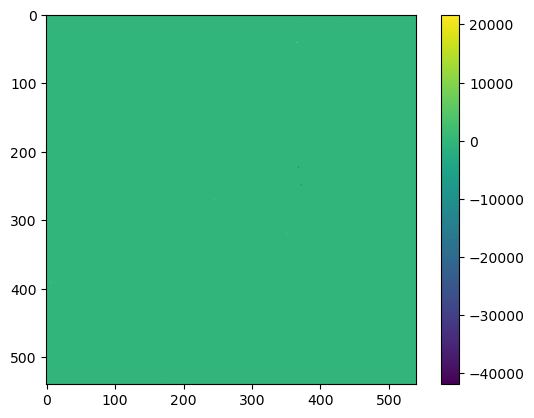

In [47]:
plt.imshow(result[0])
plt.colorbar()

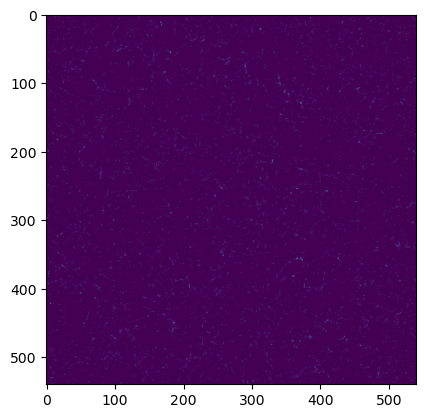

In [22]:
f = np.load('/mnt/projects/bias_mock/galaxies/rhogal_2e-03_eul_bias_gaus.npy')
plt.imshow(f[0])

In [11]:
K = 0.5
R = 1/K

    # compute FFT of the filter
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
    
    # smooth the field
field_smoothed = SL.field_smoothing(delta, W_k, threads)

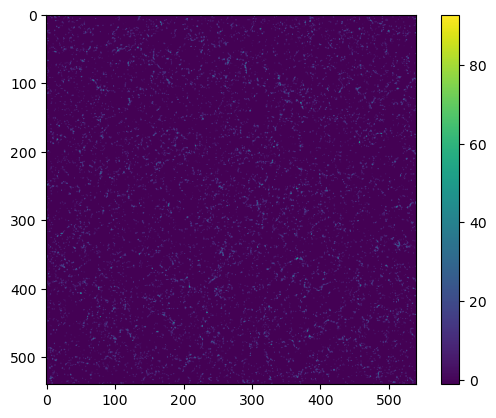

In [12]:
plt.imshow(field_smoothed[0])
plt.colorbar()

In [10]:
def positions_to_density_field(pos, box_size, grid_size):
    # Determina el tamaño de cada celda de la cuadrícula
    cell_size = box_size / grid_size
    
    # Inicializa el campo de densidad
    density_field = np.zeros((grid_size, grid_size, grid_size))
    
    # Determina las coordenadas de celda para cada posición
    cell_indices = np.floor(pos / cell_size).astype(int)
    
    # Aumenta la densidad en cada celda
    for index in cell_indices:
        density_field[tuple(index)] = density_field[tuple(index)] + 1 
    
    # Normaliza la densidad
    density_field = density_field / (cell_size**3)
    
    return density_field

In [90]:
density_field = positions_to_density_field(pos, box_size=1440.0, grid_size=540)

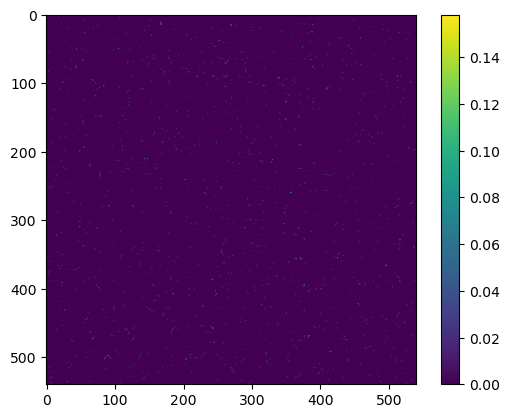

In [91]:
plt.imshow(density_field[0])
plt.colorbar()

In [96]:
np.max(density_field)

0.3691406250000001

In [97]:
np.max(delta)

7.0

In [77]:
for i in range(len(rsmooth)):
    #K = ksmooth[i]
    R = rsmooth[i]
    print(R)
    # compute FFT of the filter
    W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
    
    # smooth the field
    field_smoothed = SL.field_smoothing(delta, W_k, threads)
    
    np.save(path+'/smoothed_fields/'+filename+'_'+Filter+'_rscale_'+str(R)+'.npy', field_smoothed)

2.5
5
7.5
10
12.5


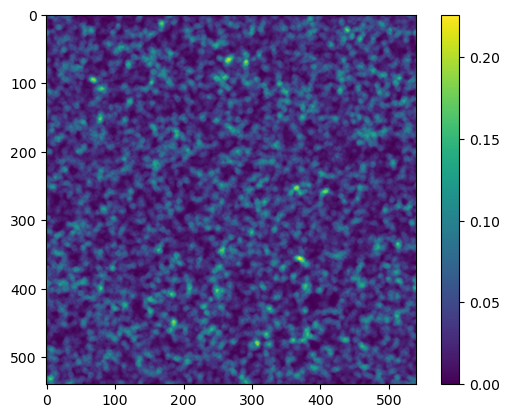

In [80]:
plt.imshow(field_smoothed[0])
plt.colorbar()

In [35]:
stop

NameError: name 'stop' is not defined

In [65]:
W_k = SL.FT_filter(BoxSize, 10, grid, Filter, threads)
    
    # smooth the field
field_smoothed = SL.field_smoothing(delta, W_k, threads)

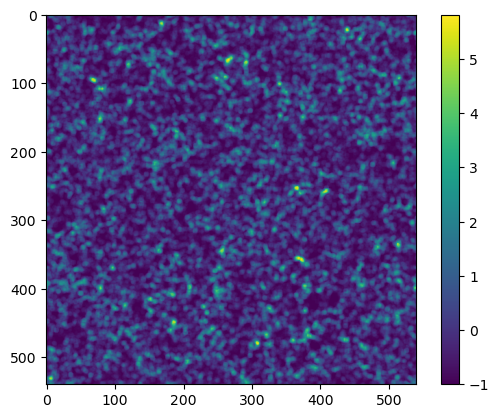

In [67]:
plt.imshow(field_smoothed[0])
plt.colorbar()

In [34]:
def positions_to_density_field(pos, box_size, grid_size):
    # Determina el tamaño de cada celda de la cuadrícula
    cell_size = box_size / grid_size
    
    # Inicializa el campo de densidad
    density_field = np.zeros((grid_size, grid_size, grid_size))
    
    # Determina las coordenadas de celda para cada posición
    cell_indices = np.floor(pos / cell_size).astype(int)
    
    # Aumenta la densidad en cada celda
    for index in cell_indices:
        density_field[tuple(index)] = density_field[tuple(index)] + 1 
    
    # Normaliza la densidad
    density_field = density_field / (cell_size**3)
    
    return density_field

In [45]:
density_field = positions_to_density_field(pos, box_size=1440.0, grid_size=540)

In [46]:
%%time
import smoothing_library as SL

BoxSize = 1440.0 #Mpc/h
R       = 5.0  #Mpc.h
grid    = 540
Filter  = 'Top-Hat'
threads = 10

# compute FFT of the filter
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)

# smooth the field
field_smoothed = SL.field_smoothing(density_field, W_k, threads)

ValueError: Buffer dtype mismatch, expected 'float32_t' but got 'double'

In [ ]:
stop

In [47]:
# density field parameters
grid    = 540    #the 3D field will have grid x grid x grid voxels
BoxSize = 1440.0 #Mpc/h ; size of box
MAS     = 'CIC'  #mass-assigment scheme
verbose = True   #print information on progress

In [39]:
file = h5py.File('/mnt/projects/bias_mock/galaxies/galpos_RedSample_2e-04.hdf5','r')
pos = file['Subhalo/SubhaloPos'][()]

In [40]:
# define 3D density field
delta = np.zeros((grid,grid,grid), dtype=np.float32)

In [41]:
# construct 3D density field
MASL.MA(pos, delta, BoxSize, MAS, verbose=verbose)


Using CIC mass assignment scheme
Time taken = 0.130 seconds



In [42]:
# at this point, delta contains the effective number of particles in each voxel
# now compute overdensity and density constrast
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

In [45]:
%%time
import smoothing_library as SL

BoxSize = 1440.0 #Mpc/h
R       = 4.0  #Mpc.h
grid    = 540
Filter  = 'Top-Hat'
threads = 10

# compute FFT of the filter
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)

# smooth the field
field_smoothed = SL.field_smoothing(delta, W_k, threads)

CPU times: user 49.1 s, sys: 14.7 s, total: 1min 3s
Wall time: 11.7 s


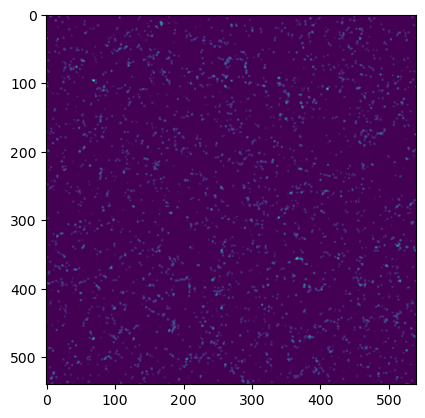

In [46]:
plt.imshow(field_smoothed[0])

In [50]:
1/0.05

20.0